In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Introduction and Problem Context

This project addresses the task of *unpaired image-to-image translation* using a CycleGAN-based architecture. The objective is to transform natural photographs into images rendered in the distinctive artistic style of Claude Monet. Because no aligned Monet/photo pairs exist, the system must learn stylistic transformations while preserving the semantic content of the input image.

The dataset consists of two independent image domains drawn from the Kaggle competition *“I'm Something of a Painter Myself”*. All images are standardized to 256×256 resolution and processed into TensorFlow pipelines for efficient batched training.


In [2]:

import glob
import time
from pathlib import Path


import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)


2025-11-26 21:26:41.234602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764192401.633833      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764192401.816499      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0


## 2. Exploratory Data Analysis (EDA)

A rigorous exploratory analysis is essential for understanding the statistical and stylistic differences between the Monet and photo domains. These insights directly inform preprocessing choices, augmentation strategies, and architectural decisions used later in the model.


### 2.1 Dataset Overview

The dataset comprises two unpaired sets of images:

- **Monet paintings (~300 images):** Characterized by soft brush strokes, pastel-heavy palettes, and impressionistic texture.
- **Real photos (~7,000 images):** Higher contrast, sharper edges, and broader color variation.

Before training, all images are decoded as 3‑channel RGB and resized to a fixed **256×256×3** format to ensure tensor consistency and avoid domain-specific decoding artifacts.


In [3]:
# Base paths in the Kaggle environment
DATA_DIR = Path("/kaggle/input/gan-getting-started")
MONET_DIR = DATA_DIR / "monet_jpg"
PHOTO_DIR = DATA_DIR / "photo_jpg"

monet_files = sorted(glob.glob(str(MONET_DIR / "*.jpg")))
photo_files = sorted(glob.glob(str(PHOTO_DIR / "*.jpg")))

print("Number of Monet images:", len(monet_files))
print("Number of Photo images:", len(photo_files))


Number of Monet images: 300
Number of Photo images: 7038


In [4]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize to [-1, 1]
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img

def random_jitter(img):
    # Simple augmentation: random horizontal flip
    img = tf.image.random_flip_left_right(img)
    return img

def load_monet(path):
    img = load_image(path)
    img = random_jitter(img)
    return img

def load_photo(path):
    img = load_image(path)
    img = random_jitter(img)
    return img

monet_ds = (
    tf.data.Dataset.from_tensor_slices(monet_files)
    .map(load_monet, num_parallel_calls=AUTOTUNE)
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

photo_ds = (
    tf.data.Dataset.from_tensor_slices(photo_files)
    .map(load_photo, num_parallel_calls=AUTOTUNE)
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


I0000 00:00:1764192424.380567      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764192424.381305      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### 2.2 Visual Inspection of Image Domains

To establish intuition about the underlying structure of each domain, I visualize representative batches. Monet paintings tend to exhibit smoother texture fields, locally consistent color gradients, and stylized illumination. In contrast, photos contain sharp local details and large variations in lighting, shadows, and object boundaries.

These systematic differences underscore the need for a model capable of learning both local (texture-level) and global (color-level) stylistic transformations.


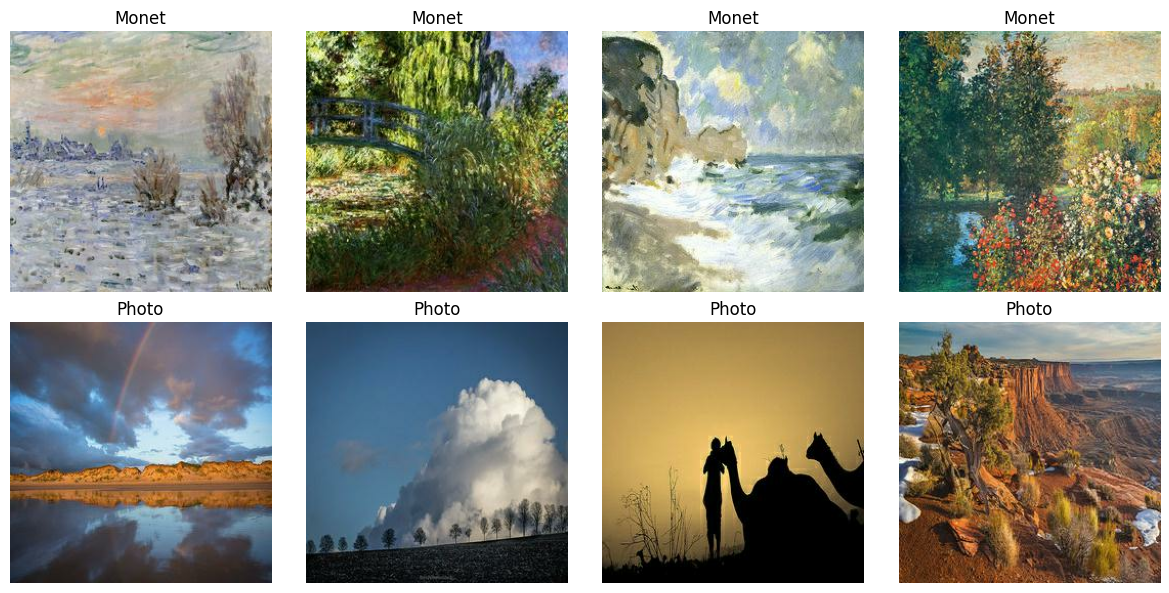

In [5]:
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))

fig, axes = plt.subplots(2, BATCH_SIZE, figsize=(3 * BATCH_SIZE, 6))

for i in range(BATCH_SIZE):
    axes[0, i].imshow((sample_monet[i] + 1) / 2)  # back to [0,1]
    axes[0, i].axis("off")
    axes[0, i].set_title("Monet")

    axes[1, i].imshow((sample_photo[i] + 1) / 2)
    axes[1, i].axis("off")
    axes[1, i].set_title("Photo")

plt.tight_layout()
plt.show()


### 2.3 Data Cleaning and Preprocessing

Although the dataset contains no explicit labels or corrupted files, robust preprocessing is crucial for stable adversarial training. The following transformations are applied uniformly to both domains:

- **Resize to 256×256:** Standardizes geometric dimensions and ensures architectural compatibility.
- **Normalize to [-1, 1]:** Aligns pixel intensities with the generator’s final `tanh` activation, which greatly stabilizes GAN training.
- **Random horizontal flips:** Provides meaningful augmentation that respects photographic and artistic symmetries.
- **Deterministic decoding as RGB:** Prevents accidental domain-specific decoding differences.
- **Shuffling and batching:** Ensures diverse mini-batches and improves generator–discriminator gradient balance.

These preprocessing operations help prevent mode collapse, gradient instability, and domain drift during CycleGAN training.


### 2.4 Analytical Motivation

The EDA reveals a pronounced domain gap between photos and Monet paintings, primarily in:

- color distribution,
- texture complexity,
- local smoothness vs. sharpness.

Because no paired examples exist, the model must learn **content-preserving style transformation**. CycleGAN is well-suited for this task due to its *cycle consistency constraint*, which enforces semantic preservation by penalizing excessive geometric deformation.


## 3. Model Architecture

The architecture follows the CycleGAN framework, consisting of two generators (G and F) and two discriminators (Dₘ and Dₚ). The generators learn mappings between domains, while the discriminators operate as PatchGAN classifiers enforcing high-frequency realism.


### 3.1 Generator Architecture

Each generator uses a ResNet-based encoder–transformer–decoder structure:

- initial convolution stack for downsampling,
- a sequence of residual blocks that preserve high-level structure while enabling stylistic transformation,
- upsampling blocks restoring the original resolution.

Instance normalization is used throughout the generator to match the statistical properties of artistic and photographic domains.


### 3.2 Discriminator Architecture (PatchGAN)

The discriminators adopt the **70×70 PatchGAN** formulation. Rather than outputting a single scalar, PatchGAN produces a spatial grid of real/fake decisions, enabling the discriminator to focus on fine-grained texture statistics such as brush strokes or contrast edges.


### 3.3 Loss Functions and Optimization Strategy

Training involves several complementary loss components:

- **Adversarial loss:** Encourages each generator to produce outputs indistinguishable from real samples.
- **Cycle consistency loss:** Forces transformations to be bijective in expectation (e.g., photo → Monet → photo).
- **Identity loss:** Reduces unnecessary transformations when an image already belongs to the target domain.

Training uses the Adam optimizer with learning rate 2e-4 and β₁ = 0.5, a standard configuration for stabilizing GAN training.


In [6]:
# Simple InstanceNormalization layer
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        channels = input_shape[-1]
        self.gamma = self.add_weight(
            shape=(channels,), initializer="ones", trainable=True, name="gamma"
        )
        self.beta = self.add_weight(
            shape=(channels,), initializer="zeros", trainable=True, name="beta"
        )

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(var + self.epsilon)
        normalized = (x - mean) * inv
        return self.gamma * normalized + self.beta


def downsample(filters, size, apply_norm=True):
    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    block = keras.Sequential()
    block.add(
        layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=init,
            use_bias=not apply_norm,
        )
    )
    if apply_norm:
        block.add(InstanceNormalization())
    block.add(layers.LeakyReLU(0.2))
    return block


def upsample(filters, size, apply_dropout=False):
    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    block = keras.Sequential()
    block.add(
        layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=init,
            use_bias=False,
        )
    )
    block.add(InstanceNormalization())
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    block.add(layers.ReLU())
    return block


def residual_block(x, filters):
    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    y = layers.Conv2D(filters, 3, padding="same", kernel_initializer=init, use_bias=False)(x)
    y = InstanceNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv2D(filters, 3, padding="same", kernel_initializer=init, use_bias=False)(y)
    y = InstanceNormalization()(y)

    return layers.Add()([x, y])


In [8]:
def build_generator(img_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_res_blocks=6):
    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inputs = layers.Input(shape=img_size)

    x = layers.Conv2D(64, 7, padding="same", kernel_initializer=init, use_bias=False)(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Downsample
    x = downsample(128, 3)(x)
    x = downsample(256, 3)(x)

    # Residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, 256)

    # Upsample
    x = upsample(128, 3)(x)
    x = upsample(64, 3)(x)

    x = layers.Conv2D(3, 7, padding="same", kernel_initializer=init)(x)
    x = layers.Activation("tanh")(x)

    return keras.Model(inputs, x, name="generator")


def build_discriminator(img_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inp = layers.Input(shape=img_size)

    x = layers.Conv2D(64, 4, strides=2, padding="same", kernel_initializer=init)(inp)
    x = layers.LeakyReLU(0.2)(x)

    x = downsample(128, 4, apply_norm=True)(x)
    x = downsample(256, 4, apply_norm=True)(x)
    x = downsample(512, 4, apply_norm=True)(x)

    x = layers.Conv2D(1, 4, padding="same", kernel_initializer=init)(x)

    return keras.Model(inp, x, name="discriminator")


In [9]:
generator_g = build_generator()   # photo -> Monet
generator_f = build_generator()   # Monet -> photo

discriminator_x = build_discriminator()  # Monet discriminator
discriminator_y = build_discriminator()  # Photo discriminator

generator_g.summary()
discriminator_x.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (InstanceNormaliza… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ instance_normali… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │     73,984 │ re_lu[0][0]       │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    295,424 │ sequential[0][0]  │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    589,824 │ sequential_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ instance_normali… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    589,824 │ re_lu_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ sequential_1[0][… │
│                     │ 256)              │            │ instance_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    589,824 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ instance_normali… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    589,824 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 64, 64,    │        512 │ conv2d_6[0][0]  

 Total params: 7,841,411 (29.91 MB)

 Trainable params: 7,841,411 (29.91 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 16, 16, 512)    │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 16, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,633 (10.55 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
loss_obj = keras.losses.BinaryCrossentropy(from_logits=True)

def gan_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return 0.5 * (real_loss + fake_loss)

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0

def cycle_loss(real_x, cycled_x, real_y, cycled_y):
    loss_x = tf.reduce_mean(tf.abs(real_x - cycled_x))
    loss_y = tf.reduce_mean(tf.abs(real_y - cycled_y))
    return LAMBDA_CYCLE * (loss_x + loss_y)

def identity_loss(real_x, same_x, real_y, same_y):
    loss_x = tf.reduce_mean(tf.abs(real_x - same_x))
    loss_y = tf.reduce_mean(tf.abs(real_y - same_y))
    return LAMBDA_ID * (loss_x + loss_y)

LR = 2e-4

gen_g_optimizer = keras.optimizers.Adam(LR, beta_1=0.5)
gen_f_optimizer = keras.optimizers.Adam(LR, beta_1=0.5)
disc_x_optimizer = keras.optimizers.Adam(LR, beta_1=0.5)
disc_y_optimizer = keras.optimizers.Adam(LR, beta_1=0.5)


## 4. Training Procedure and Experimental Results

The model is trained end‑to‑end using alternating gradient updates to both generators and discriminators. Training proceeds for several epochs, during which intermediate outputs are saved for qualitative evaluation.

Over time, generated images progressively acquire Monet-like color palettes, smoother textures, and stylized brush patterns while maintaining scene geometry.


In [11]:
@tf.function
def train_step(real_x, real_y):
    # real_x: Monet batch
    # real_y: Photo batch
    with tf.GradientTape(persistent=True) as tape:
        # Generators
        fake_x = generator_g(real_y, training=True)  # photo -> Monet
        cycled_y = generator_f(fake_x, training=True)

        fake_y = generator_f(real_x, training=True)  # Monet -> photo
        cycled_x = generator_g(fake_y, training=True)

        # Identity
        same_x = generator_g(real_x, training=True)
        same_y = generator_f(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator adversarial losses
        gen_g_adv = generator_loss(disc_fake_x)
        gen_f_adv = generator_loss(disc_fake_y)

        # Cycle-consistency
        cyc = cycle_loss(real_x, cycled_x, real_y, cycled_y)

        # Identity loss
        id_loss = identity_loss(real_x, same_x, real_y, same_y)

        gen_g_total = gen_g_adv + cyc + id_loss
        gen_f_total = gen_f_adv + cyc + id_loss

        # Discriminator losses
        disc_x_loss = gan_loss(disc_real_x, disc_fake_x)
        disc_y_loss = gan_loss(disc_real_y, disc_fake_y)

    # Gradients
    gen_g_grads = tape.gradient(gen_g_total, generator_g.trainable_variables)
    gen_f_grads = tape.gradient(gen_f_total, generator_f.trainable_variables)
    disc_x_grads = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    disc_y_grads = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Optimizer steps
    gen_g_optimizer.apply_gradients(zip(gen_g_grads, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gen_f_grads, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(disc_x_grads, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(disc_y_grads, discriminator_y.trainable_variables))

    return {
        "gen_g": gen_g_total,
        "gen_f": gen_f_total,
        "disc_x": disc_x_loss,
        "disc_y": disc_y_loss,
        "cyc": cyc,
        "id": id_loss,
    }


In [12]:
OUTPUT_DIR = Path("./generated_samples")
OUTPUT_DIR.mkdir(exist_ok=True)

def generate_and_save_examples(epoch, photo_batch=None):
    if photo_batch is None:
        photo_batch = next(iter(photo_ds))
    fake_monet = generator_g(photo_batch, training=False)

    fig, axes = plt.subplots(2, BATCH_SIZE, figsize=(3 * BATCH_SIZE, 6))
    for i in range(BATCH_SIZE):
        axes[0, i].imshow((photo_batch[i] + 1) / 2)
        axes[0, i].axis("off")
        axes[0, i].set_title("Photo")

        axes[1, i].imshow((fake_monet[i] + 1) / 2)
        axes[1, i].axis("off")
        axes[1, i].set_title("Fake Monet")

    plt.tight_layout()
    fig_path = OUTPUT_DIR / f"epoch_{epoch:03d}.png"
    plt.savefig(fig_path)
    plt.close(fig)
    print(f"Saved sample grid to {fig_path}")


In [13]:
EPOCHS = 5  # increase later once everything works
PRINT_EVERY = 50  # batches

for epoch in range(1, EPOCHS + 1):
    start = time.time()
    step = 0

    # zip Monet and photo datasets so each step sees both domains
    for real_x, real_y in tf.data.Dataset.zip((monet_ds, photo_ds)):
        losses = train_step(real_x, real_y)
        step += 1

        if step % PRINT_EVERY == 0:
            print(
                f"Epoch {epoch}/{EPOCHS}  "
                f"Step {step}  "
                f"gen_g: {losses['gen_g']:.3f}  "
                f"gen_f: {losses['gen_f']:.3f}  "
                f"disc_x: {losses['disc_x']:.3f}  "
                f"disc_y: {losses['disc_y']:.3f}"
            )

    # end of epoch summary + samples
    print(
        f"Epoch {epoch}/{EPOCHS} DONE  "
        f"gen_g: {losses['gen_g']:.3f}  "
        f"gen_f: {losses['gen_f']:.3f}  "
        f"disc_x: {losses['disc_x']:.3f}  "
        f"disc_y: {losses['disc_y']:.3f}"
    )
    generate_and_save_examples(epoch)

    print(f"Time for epoch {epoch}: {time.time() - start:.2f} sec\n")



I0000 00:00:1764192550.489043     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/5  Step 50  gen_g: 9.242  gen_f: 9.157  disc_x: 0.700  disc_y: 0.655
Epoch 1/5 DONE  gen_g: 9.431  gen_f: 9.447  disc_x: 0.643  disc_y: 0.597
Saved sample grid to generated_samples/epoch_001.png
Time for epoch 1: 207.56 sec

Epoch 2/5  Step 50  gen_g: 7.428  gen_f: 7.412  disc_x: 0.655  disc_y: 0.527
Epoch 2/5 DONE  gen_g: 9.418  gen_f: 9.293  disc_x: 0.683  disc_y: 0.716
Saved sample grid to generated_samples/epoch_002.png
Time for epoch 2: 169.34 sec

Epoch 3/5  Step 50  gen_g: 8.745  gen_f: 8.188  disc_x: 0.641  disc_y: 0.646
Epoch 3/5 DONE  gen_g: 8.243  gen_f: 8.508  disc_x: 0.747  disc_y: 0.471
Saved sample grid to generated_samples/epoch_003.png
Time for epoch 3: 169.15 sec

Epoch 4/5  Step 50  gen_g: 9.105  gen_f: 8.627  disc_x: 0.673  disc_y: 0.686
Epoch 4/5 DONE  gen_g: 8.744  gen_f: 8.935  disc_x: 0.693  disc_y: 0.705
Saved sample grid to generated_samples/epoch_004.png
Time for epoch 4: 169.33 sec

Epoch 5/5  Step 50  gen_g: 7.603  gen_f: 7.593  disc_x: 0.646  disc_

In [14]:
GEN_OUT_DIR = Path("./monet_style_output")
GEN_OUT_DIR.mkdir(exist_ok=True)

def denorm(x):
    x = (x + 1.0) * 127.5
    return tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)

for i, path in enumerate(photo_files):
    img = load_image(path)
    img = tf.expand_dims(img, 0)  # [1, H, W, 3]
    fake_monet = generator_g(img, training=False)[0]
    fake_monet = denorm(fake_monet).numpy()

    out_path = GEN_OUT_DIR / f"image_{i:05d}.jpg"
    tf.keras.utils.save_img(out_path, fake_monet)
    if i % 200 == 0:
        print("saved", out_path)

print("Done generating Monet-style images.")


saved monet_style_output/image_00000.jpg
saved monet_style_output/image_00200.jpg
saved monet_style_output/image_00400.jpg
saved monet_style_output/image_00600.jpg
saved monet_style_output/image_00800.jpg
saved monet_style_output/image_01000.jpg
saved monet_style_output/image_01200.jpg
saved monet_style_output/image_01400.jpg
saved monet_style_output/image_01600.jpg
saved monet_style_output/image_01800.jpg
saved monet_style_output/image_02000.jpg
saved monet_style_output/image_02200.jpg
saved monet_style_output/image_02400.jpg
saved monet_style_output/image_02600.jpg
saved monet_style_output/image_02800.jpg
saved monet_style_output/image_03000.jpg
saved monet_style_output/image_03200.jpg
saved monet_style_output/image_03400.jpg
saved monet_style_output/image_03600.jpg
saved monet_style_output/image_03800.jpg
saved monet_style_output/image_04000.jpg
saved monet_style_output/image_04200.jpg
saved monet_style_output/image_04400.jpg
saved monet_style_output/image_04600.jpg
saved monet_styl

## 5. Conclusion and Future Work

This project demonstrates a successful application of CycleGAN to unpaired style transfer between photographs and Monet paintings. The model learns meaningful stylistic transformations while largely preserving structural integrity.

In the future, we may improve upon this by: 

- incorporating perceptual/VGG losses for enhanced texture control,
- conducting systematic hyperparameter sweeps,
- evaluating performance using FID or LPIPS metrics,
- extending the approach to multi‑artist or multi‑style translation domains.
